In [20]:
from pathlib import Path
from dataclasses import dataclass
from pprint import pprint

from PIL import Image

import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import ToPILImage
from torchvision.models.resnet import ResNet
from torchvision.models import WeightsEnum
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import resnet50, ResNet50_Weights

naro = Path("/mnt/a/data/ott-or-not/north_american_river_otter_100")

In [21]:
if torch.cuda.is_available():
    torch.device("cuda")
    print(f"Using CUDA backend on device '{torch.cuda.get_device_name(0)}'.")
else:
    torch.device("cpu")
    print("Using CPU backend.")

Using CUDA backend on device 'NVIDIA GeForce RTX 3080 Ti'.


In [22]:
@dataclass(frozen=True)
class OtterPredictionResult:
    """
    Utility container for the predictions of a known otter image.
    """
    category: str
    category_score: float
    otter_score: float
    file_path: Path = None

class OtterScorer:
    def __init__(self) -> None:

        # Instantiate the model with default weights and set it to eval mode
        self.weights = ResNet34_Weights.DEFAULT
        self.model = resnet34(weights=self.weights)
        self.model.eval()

        # Store the preprocess transforms for later use 
        self.preprocess = self.weights.transforms()

        # Look up the index of "otter" among the model's output classes
        self.categories: list[str] = self.weights.meta["categories"]
        self._otter_index = self.categories.index("otter")

    def preprocess_image(self, item: Image.Image | Path | str | OtterPredictionResult) -> Image.Image:
        """
        Apply the model's preprocessing transforms to an image.

        This function is useful for diagnostics and interpretability. Typically the preprocessing
        transforms directly produce a tensor. But this function converts the tensor back to an image,
        also removing the scaling and normalization applied by the transforms in order to make the
        image more human-interpretable.
        """
        match item:
            case Image.Image as image_class:
                img = image_class
            case str(s):
                img = read_image(Path(s).expanduser())
            case Path(p):
                img = read_image(p.expanduser())
            case OtterPredictionResult as pred:
                img = read_image(pred.file_path)

        # Apply the preprocessing transforms
        tensor = self.preprocess(img)

        # Undo the normalization and scaling transformations
        transform_means: list[float] = self.preprocess.mean
        transform_stdev: list[float] = self.preprocess.std
        for i in range(3):
            tensor[i] = tensor[i] * transform_stdev[i] + transform_means[i]
        
        tensor = torch.clip(tensor, 0, 1)

        # Convert the tensor back to an image
        return ToPILImage()(tensor)



    def score_image_at_path(self, path: Path | str) -> OtterPredictionResult:
        
        if isinstance(path, str):
            path = Path(path)

        # Obtain a prediction
        img = read_image(path.expanduser())
        batch = self.preprocess(img).unsqueeze(0)
        prediction = self.model(batch).squeeze(0).softmax(0)

        # Package and return results
        category_id = prediction.argmax().item()
        return OtterPredictionResult(
            category=self.categories[category_id],
            category_score=prediction[category_id].item(),
            otter_score=prediction[self._otter_index].item(),
            file_path=path
        ) 

scorer = OtterScorer()

In [23]:
image_of_interest = naro / "20120830-139jdj.jpg"

In [24]:
result = scorer.score_image_at_path(image_of_interest)
pprint(result)

OtterPredictionResult(category='otter',
                      category_score=0.8854503631591797,
                      otter_score=0.8854503631591797,
                      file_path=PosixPath('/mnt/a/data/ott-or-not/north_american_river_otter_100/20120830-139jdj.jpg'))


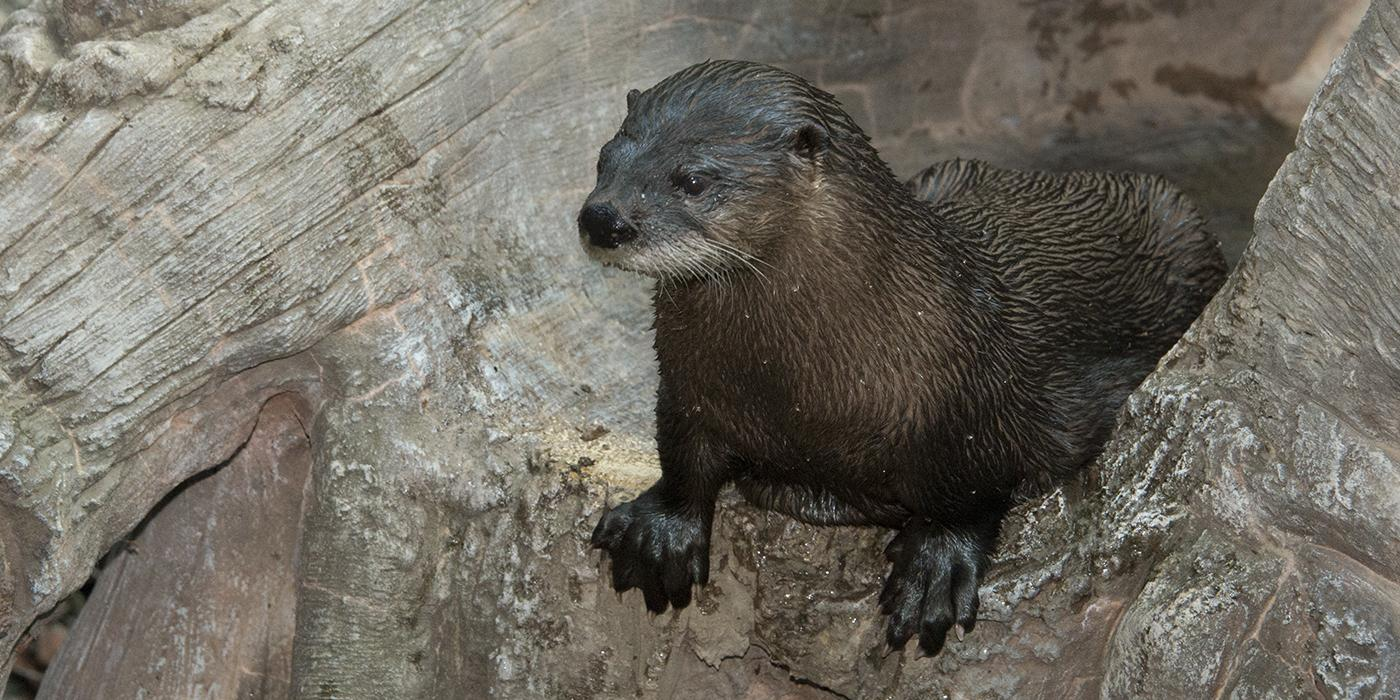

In [25]:
img = Image.open(result.file_path)
img.show()

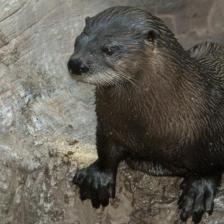

In [26]:
scorer.preprocess_image(result).show()